In [1]:
import PIL.Image
import numpy as np
import pylab as py
import cv2
from PIL import Image
import sklearn.decomposition

(960, 540)
(1920, 1080)


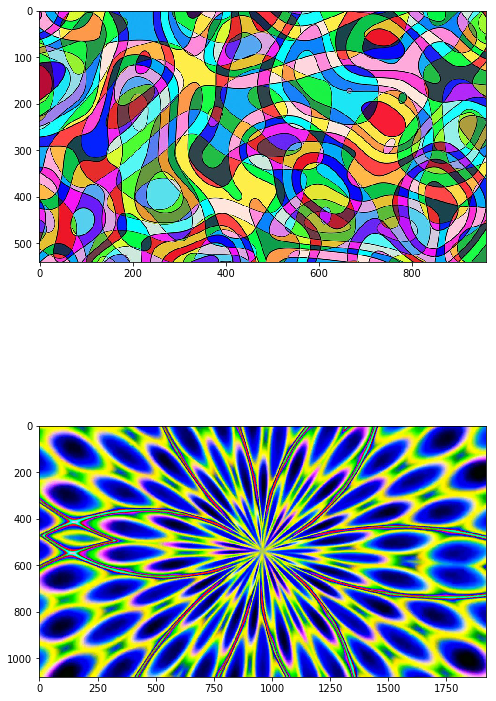

In [11]:
show_these = ['3.jpg','4.jpg'] # there are 1-13.tiff's

# read in images and display 
fig = py.figure(figsize=(8,14))
for (i,file) in enumerate(show_these):
    py.subplot(2,1,i+1)
    img = PIL.Image.open('color_images/'+file)
    py.imshow(img, cmap=py.cm.Greys_r)
    #images to grayscale
    image = np.asarray(img, 'double').transpose() 
    image = image[0,:,:]
    #reshaping array to not include color for images 
    print(image.shape)

In [25]:
def collect_natural_patches_c(num_patches = 100000, patch_width = 8):
  """ collects image patches"""

  max_tries = num_patches * 50
  image_width = 200
  
  img_first_patch = 0 # the first patch number accepted from an image
  img_first_try = 0 # the first attempt to take a patch from the image
  patch_cnt = 0 # number of collected patches
  try_cnt = 0 # number of attempted collected patches
  num_pixels = 3 * patch_width * patch_width

  patch_sample = np.zeros([3,patch_width,patch_width],float)
  patch = np.zeros([num_pixels],float)
  
  img_patches = np.zeros([num_pixels,num_patches],float)

  # change the image sampled from
  nat_img_cnt = 1  
  image = PIL.Image.open('Color_Images/' + str(nat_img_cnt) + '.jpg')
  image = np.asarray(image, 'double').transpose() 
  image = image[0:3,:,:]
  # normalizing the image
  image -= image.mean()
  image /= image.std()
  
  
  # collect the patches
  while patch_cnt < num_patches and try_cnt < max_tries:
    try_cnt += 1  # number of total patches attempted

    if (try_cnt - img_first_try) > max_tries/3 or \
      (patch_cnt - img_first_patch) > num_patches/3:
      # change the image sampled from
      nat_img_cnt += 1
      image = PIL.Image.open('color_images/' + str(nat_img_cnt) + '.jpg')
      
      image = np.asarray(image, 'double').transpose() 
      image = image[0:3,:,:]
      
      
      
      image -= image.mean()
      image /= image.std()
      
      img_first_patch = patch_cnt
      img_first_try = try_cnt
    
      # update on every switch of images
      print (int(100 * float(patch_cnt)/num_patches),' percent complete')
    
    px = np.random.randint(0,image_width - patch_width)
    py = np.random.randint(0,image_width - patch_width)
        
    patch_sample = image[:,px:px+patch_width,py:py+patch_width].copy()
    
    patch_std = patch_sample.std()
    
    if patch_std > 0.0: # > 0 to remove blank/uninteresting patches for speed
      # create the patch vector     
      patch = np.reshape(patch_sample, num_pixels)   
      patch = patch - np.mean(patch)         
      img_patches[:,patch_cnt] = patch.copy()
      patch_cnt += 1
  return img_patches
        
patches_mat_c = collect_natural_patches_c(num_patches = 100000, patch_width = 8)
print('\nshape of the extracted image patch data:', patches_mat_c.shape)


33  percent complete
66  percent complete

shape of the extracted image patch data: (192, 100000)


In [26]:
def show_patches_mat_c(pre_patches, show_patch_num = 16, display=True):
  """ this function generates a 2D array to display image patches (assuming square) """
  
  patches = pre_patches
    
  tot_patches = patches.shape[1]
  data_dim = patches.shape[0]
  patch_width = int(np.round(np.sqrt(data_dim))) - 6
  
  # extract show_patch_num patches
  disp_patch = np.zeros([data_dim, show_patch_num], float)
  for i in range(0,show_patch_num):
    patch_i = i * tot_patches // show_patch_num
  
    patch = patches[:,patch_i].copy()
    pmax  = patch.max()
    pmin = patch.min()
    # fix patch range from min to max to 0 to 1
    if pmax > pmin: 
      patch = (patch - pmin) / (pmax - pmin)
    disp_patch[:,i] = patch.copy()

  bw = 5    # border width
  pw = patch_width
  
  patches_y = int(np.sqrt(show_patch_num))
  patches_x = int(np.ceil(float(show_patch_num) / patches_y))
  patch_img = disp_patch.max() * np.ones([3,(pw + bw) * patches_x - bw,
    patches_y * (pw + bw) - bw], float)
  for i in range(0,show_patch_num): 
    y_i = i // patches_y
    x_i = i % patches_y 

    reshaped = disp_patch[:,i].reshape((3,8,8))
    full_patch = np.zeros([3, pw, pw], float)
    full_patch[0:3,0:8,0:8] = reshaped[:,:,:].copy()
    patch_img[:,x_i*(pw+bw):x_i*(pw+bw)+pw,y_i*(pw+bw):y_i*(pw+bw)+pw] = full_patch
  
  if display:
    
    py.imshow(patch_img[:,:,:].T, interpolation='nearest')
    py.axis('off')
  return

33  percent complete
66  percent complete


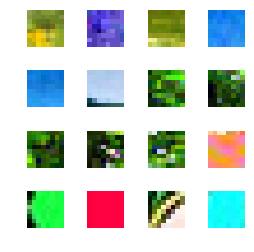

In [27]:
collect_natural_patches_c(num_patches = 100000, patch_width = 8)
show_patches_mat_c(patches_mat_c)

Quality of image representation using only 40% as much data per patch 
(using only responses along these 10 components instead of the full 64 dimensions): 
 68.45189610305631 %

Percentage of data explained by each filter:
 [30.44398314 16.38755544  5.56377756  4.75393616  2.6275388   2.19390502
  1.95202083  1.66358793  1.45273177  1.41285944]


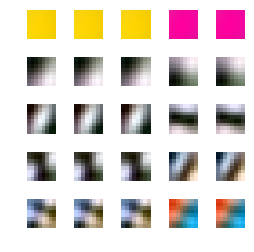

In [15]:
# finding PCA components

pcatemp = sklearn.decomposition.PCA(n_components=10)
pcafit = pcatemp.fit(np.transpose(patches_mat_c))

print('Quality of image representation using only 40% as much data per patch',
      '\n(using only responses along these 10 components instead of the full 64 dimensions):',
      '\n',np.sum(100*pcafit.explained_variance_ratio_),'%')

print('\nPercentage of data explained by each filter:\n',100*pcafit.explained_variance_ratio_)

pca_comp = pcafit.components_
show_patches_mat_c(np.transpose(pca_comp), 25)

#this function finds 10 PCA components from these image patches
#PCA does not resemble receptive fields, its often used as preprocessing for ICA

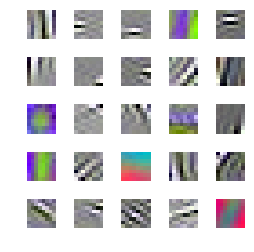

In [16]:
#finding ICA components
icatemp_c = sklearn.decomposition.FastICA(n_components=50) # note, sensitive to n_components
icafit_c = icatemp_c.fit(np.transpose(patches_mat_c))

ica_comp_c = icafit_c.components_

show_patches_mat_c(np.transpose(ica_comp_c), 25)